In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import plotly.graph_objs as go

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
%run DataBaseTraitement.ipynb
# from DataBaseTraitement import persisetDB as db

All existing tables: ()
l_recipe_ingredient user was found
INGREDIENT :  insert into ingredient
            (name,id_ingredient,url_pic) values("nappage","1","https://assets\.afcdn\.com/recipe/20100101/ingredient_default_w96h96c1\.jpg");
INGREDIENT :  insert into ingredient
            (name,id_ingredient,url_pic) values("farine\ sans\ gluten","2","https://assets\.afcdn\.com/recipe/20100101/ingredient_default_w96h96c1\.jpg");
INGREDIENT :  insert into ingredient
            (name,id_ingredient,url_pic) values("lait\ de\ riz","3","https://assets\.afcdn\.com/recipe/20210308/118438_w96h96c1cx315cy276cxb631cyb553\.jpg");
INGREDIENT :  insert into ingredient
            (name,id_ingredient,url_pic) values("tofu\ soyeux","4","https://assets\.afcdn\.com/recipe/20171110/74687_w96h96c1cx2651cy2442cxb5302cyb4884\.jpg");
INGREDIENT :  insert into ingredient
            (name,id_ingredient,url_pic) values("macreuse","5","https://assets\.afcdn\.com/recipe/20100101/ingredient_default_w96h96c1\.jpg")

In [3]:
def readJson(file):
    json_file = open(file, encoding='utf-8')
    data = json_file.read()
    recipes = json.loads(data)
    json_file.close()
    return recipes

In [4]:
gram_conv_dict ={
    'g':1,
    'kg':1,
    'l': 1000,
    'cl':10,
    'ml': 1
    }
def convert2num(string_num):
    # print("to convert in int",string_num)
    try:
        return int(string_num)
    except ValueError:
        return 1

def get_in_grams(unit):
    # print("to convert in g",unit)
    try:
        return gram_conv_dict[unit.lower()]
    except:
        print('don\'t know how much grams is present in 1',unit+'.')

    return 1

In [5]:
def createVectorQty(listIngredient, ListRecette):
    dataset = []
    listProvisoire = []
    vectorSize = len(listIngredient)
    for i, recette in enumerate(ListRecette):
        vector = np.zeros(vectorSize)
        for index, ingredient in enumerate(recette['ingredients']):
            listProvisoire.append(ingredient['nom_ingre'])
            for k,listIngre in enumerate(listIngredient):
                if listIngre in listProvisoire:
                    # print('Nom Ingre:', ingredient['nom_ingre'])
                    # print("Raw qty:",ingredient['quantity'],ingredient['unity'])
                    convertedDate = convert2num(ingredient['quantity'])*get_in_grams(ingredient['unity'])
                    # print("converted data:", convertedDate)
                    vector[k]= convertedDate
            listProvisoire = []
        dataset.append(vector)
    return np.array(dataset)

In [43]:
def getListIngredient(recipesList):
    listIngre = []
    cpt_ingredient = {}
    frequence = 5
    for index, recipe in enumerate(recipesList):
        for i, ingredient in enumerate(recipe['ingredients']):
            if ingredient['nom_ingre'] not in listIngre:
                listIngre.append(ingredient['nom_ingre'])
                cpt_ingredient[ingredient['nom_ingre']] = 1
            else:
                  cpt_ingredient[ingredient['nom_ingre']] += 1

    d = sorted(cpt_ingredient.items(), key=lambda x: x[1], reverse=True)
#     print("counter:",d)
    for k,v in cpt_ingredient.items():
        if v < frequence or v > 400:
            listIngre.remove(k)
#     print(lemmitiseIngredient)
    tmp = recipesList   
    for index, recipe in enumerate(recipesList):
        listIngreTmp = []
        for k, ingredient in enumerate(recipe['ingredients']):
            listIngreTmp.append(ingredient['nom_ingre'])
        if  any(x in listIngreTmp for x in listIngre) == False:
            del tmp[index]
            
    done = set() 
    newRecipes = []
    for key, value in enumerate(tmp):
        nom = value['nom'].lower()
        # lemmitiseRecette= StemmingData(nom)
#         print(lemmitiseRecette)
        if nom not in done:
            done.add(nom)  # note it down for further iterations
            newRecipes.append(value)
    print('new Recipes length',len(newRecipes))
    for key, value in enumerate(newRecipes):
        value['id_cluster'] = key

    # print("Recettes après traitement:",len(newRecipes))
    return  listIngre,newRecipes

In [7]:
def createVector(listIngredient, ListRecette):
    dataset = []
    listProvisoire = []
    vectorSize = len(listIngredient)
    recetteSize = len(ListRecette)
    for i, recette in enumerate(ListRecette):
        vector = np.zeros(vectorSize)
        for index, ingredient in enumerate(recette['ingredients']):
            listProvisoire.append(ingredient['nom_ingre'])
            for k,listIngre in enumerate(listIngredient):
                if listIngre in listProvisoire:
                    vector[k]= 1
            listProvisoire = []
        dataset.append(vector)
#         print(dataset)
    return np.array(dataset)

In [8]:
#Inertia measures how well a dataset was clustered by K-Means
# It is calculated by measuring the distance between each data point and its centroid, 
#squaring this distance, and summing these squares across one cluster.
def chooseOptimalCluster(dataset):
    sse = []
    k_list = range(1, 15)
    for k in k_list:
        km = KMeans(n_clusters=k)
        km.fit(dataset)
        sse.append([k, km.inertia_])
    oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
    plt.figure(figsize=(12,6))
    plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
    plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [9]:
def kmeans(dataset, n_clusters,n_component):
    pca = PCA(n_component)# a changer
    #Transform the data
    dataset = pca.fit_transform(dataset)
#     print("len dataset",len(dataset))
    kmeans = KMeans(n_clusters=n_clusters,init="random", random_state= 10)
    label = kmeans.fit_predict(dataset)
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)
    plt.figure(figsize = (8,8))
    for i in u_labels:
        plt.scatter(dataset[label == i , 0] , dataset[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color="black")
    plt.legend()
    plt.show()
    
    dataReturn = []
    for data in dataset:
        #generate an array with strings
        x_arrstr = np.char.mod('%f', data)
        #combine to a string
        x_str = ";".join(x_arrstr)
        dataReturn.append(x_str)
    return kmeans,dataReturn

In [10]:
# Using PCA to reduce the dataset into 3 principal 
def pca(dataset, n_clusters,n_component):
    kmeans_scale = KMeans(n_clusters=n_clusters, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(dataset)
    labels_scale = kmeans_scale.labels_
    pca2 = PCA(n_components=n_component).fit(dataset)
    pca2d = pca2.transform(dataset)
    plt.figure(figsize = (10,10))
    sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                    hue=labels_scale, 
                    palette='Set1',
                    s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
    plt.legend()
    plt.ylabel('PC2')
    plt.xlabel('PC1')
    plt.show()
    
    Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
    labels = labels_scale
    trace = go.Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], 
            mode='markers',marker=dict(color = labels, colorscale='Viridis', 
            size = 10, line = dict(color = 'gray',width = 5)))
    layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    fig.show()


In [11]:
#Feature Reduction via PCA
def featureReduce(df_scale):
    n_components = len(df_scale[0])
    pca = PCA(n_components=n_components)
    pca_scale = pca.fit(df_scale)
    print(pca_scale)
    variance = pca.explained_variance_ratio_
    var = np.cumsum(np.round(variance, 3)*100)
    plt.figure(figsize=(12,6))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    
    
    #check the variance ratio
    pca = PCA(n_components=6)
    pca_scale = pca.fit_transform(df_scale)
    pca_df_scale = pd.DataFrame(pca_scale, columns=['pc1','pc2','pc3','pc4','pc5','pc6'])
    print("pourcentage of the first PCAs")
    print("we will use 70 features instead of 338")
    print(pca.explained_variance_ratio_)
    return pca_scale

In [12]:
# Applying KMeans to PCA Principal Components
def elbowPCA(pca_df_scale):
    sse = []
    k_list = range(1, 15)
    for k in k_list:
        km = KMeans(n_clusters=k)
        km.fit(pca_df_scale)
        sse.append([k, km.inertia_])

    pca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
    plt.figure(figsize=(12,6))
    plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
    plt.title('Optimal Number of Clusters using Elbow Method (PCA_Scaled Data)')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

In [13]:
# Silhouette analysis can be used to study the separation distance between the resulting clusters
def silhouetteApres(pca_df_scale):
    kmeans_scale = KMeans(n_clusters=5, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(pca_df_scale)
    silhouette = silhouette_score(pca_df_scale, kmeans_scale.labels_, metric='euclidean')
    print('KMeans Scaled Silhouette Score Avant: {}'
          .format(silhouette_score(pca_df_scale, kmeans_scale.labels_, metric='euclidean')))
    labels_scale = kmeans_scale.labels_

    return silhouette

le nombre de recettes raw 9879
new Recipes length 7757
PCA(n_components=665)
pourcentage of the first PCAs
we will use 70 features instead of 338
[0.01615897 0.01380676 0.01165628 0.01151097 0.01139707 0.01074814]


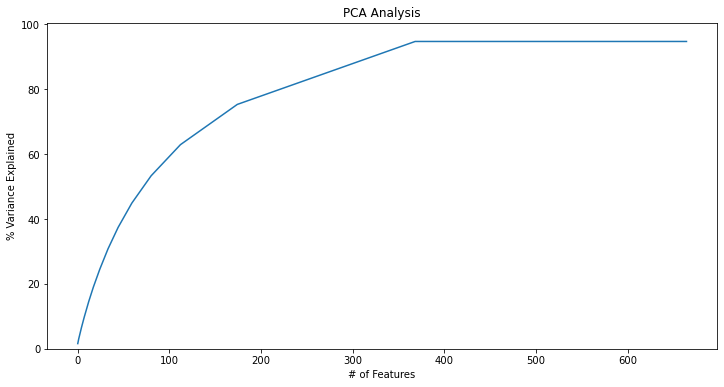

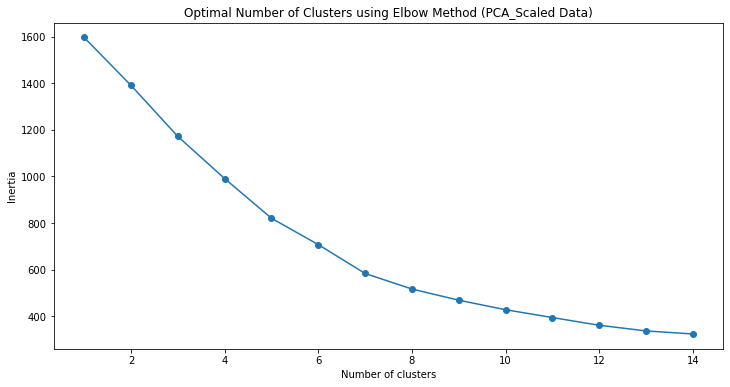

In [22]:
file = "testingFile.json"
ListRecetteRaw = readJson(file)
print("le nombre de recettes raw",len(ListRecetteRaw))
listIngredient,listRecette = getListIngredient(ListRecetteRaw)
dataset1 = createVector(listIngredient, listRecette)
# dataset2 = createVectorQty(listIngredient,listRecette)

# print(len(dataset[77]), "vector 0")
pca_scale = featureReduce(dataset1)
elbowPCA(pca_scale)
# silhouetteApres(pca_scale,20)

In [15]:
def get_ingredients(recipes):
        dict = {}
        for r in recipes:
            for i in r.get('ingredients', []):
                id = i.get('id_ingre')
                if id in dict:
                    dict[id][1] += 1
                else:
                    dict[id] = [i.get('nom_ingre'), 1]
        return dict
def get_ingr_rank(recipes):
    dict = get_ingredients(recipes)
    return sorted(dict.items(), key=lambda i: i[1][1], reverse=True)
#         return {k: v for k, v in sorted(listIngre.items(), key=lambda item: item[1], reverse=True)}

In [16]:
def linkCluster(kmeans,dataset,recipes,n_clusters,file_name):
    # print(dataset[0])
    recipes_db = []
    numCluster = 6
    for label in range(n_clusters):
        if file_name == '_first':
            numCluster = label
        else:
            numCluster += 1
        label_index = [i for i, x in enumerate(kmeans.labels_) if x == label]
#         recipes_cluster = [recipes[index] for index in label_index]
        recipes_cluster = []
        for index in label_index:
            for recipe in recipes:
                 if(recipe['id'] == index):
                        recipes_cluster.append(recipe)
        ingredients_ranked = get_ingr_rank(recipes_cluster)
        # print("\n\nCluster", label, ":")
        ranking_string = ""
        for index in range(len(ingredients_ranked)):
            ingredient = ingredients_ranked[index]
            if ingredient[1][1] != np.nan and ingredient[1][0] != np.nan:
                ranking_string += ingredient[1][0] + " (" + str(ingredient[1][1]) + "), "
        # print(ranking_string + '\n')
        for index_recipe in label_index:
            for recipe in recipes:
                if(recipe['id_cluster'] == index_recipe):
                    recipe['cluster'] = numCluster
                    recipe['coordonnees'] = dataset[index_recipe]
                    recipes_db.append(recipe)
#                     print("Id recette:",recipe['id'],'\n')
#                     print("Nom Recette:",recipe['nom'])
#                     print("List Ingredients:")
                    # for ingrediet in recipe['ingredients']:
                        # print(ingrediet['nom_ingre'])
    file = "data/" + file_name + ".json"
    with open(file, "w") as outfile:
        json.dump(recipes_db, outfile)
    # persisetDB(recipes_db)
    print("recipes_db",len(recipes_db))

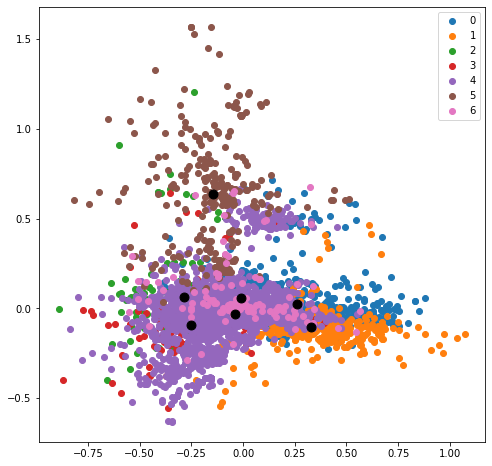

/Users/mamadoubelladiallo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



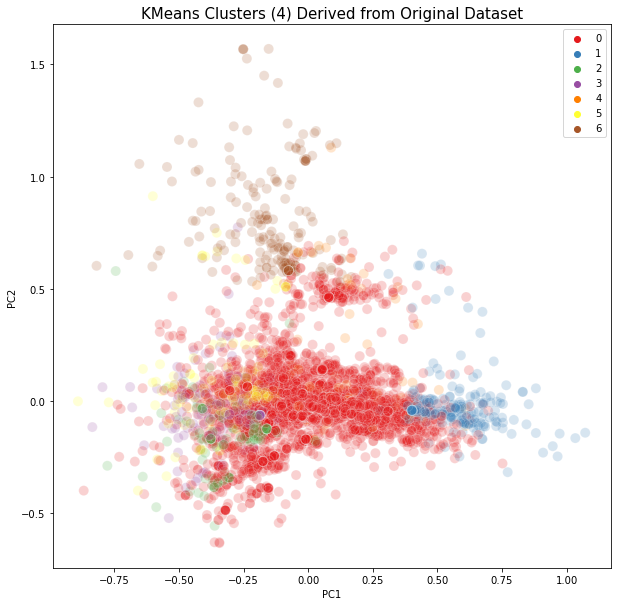

recipes_db 7757


In [23]:
# kmeans, pca, linkCluster 
# 70 components et 7 clusters avant
n_clusters = 7
n_component = 100
file_name = '_first'
k,d = kmeans(dataset1,n_clusters,n_component)

pca(dataset1,n_clusters,n_component)
linkCluster(k,d,listRecette,n_clusters,file_name)


{0: Counter({0: 836}), 1: Counter({1: 451}), 2: Counter({2: 187}), 3: Counter({3: 212}), 4: Counter({4: 5633}), 5: Counter({5: 311}), 6: Counter({6: 127})}
new Recipes length 5468
PCA(n_components=504)
pourcentage of the first PCAs
we will use 70 features instead of 338
[0.02678268 0.01980802 0.01842349 0.01783347 0.01580935 0.01486855]


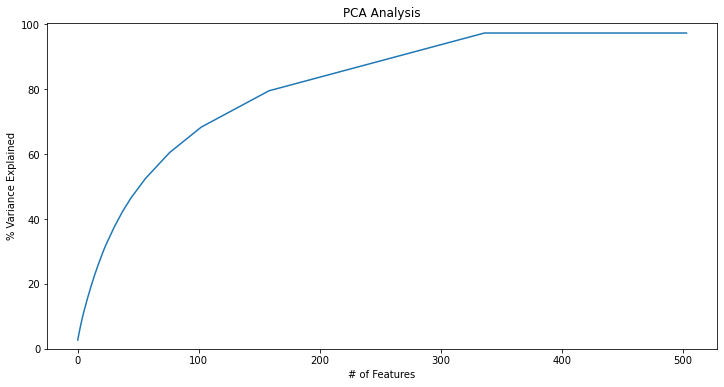

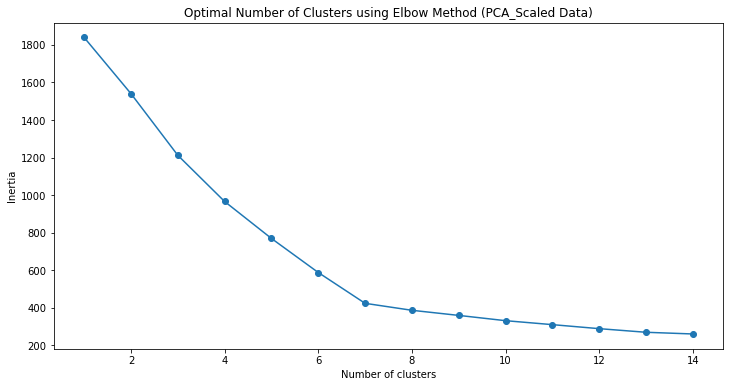

In [45]:
from collections import Counter
from itertools import groupby
data = readJson('data/_first.json')
f = lambda data: data['cluster']
dct = {k: Counter(d['cluster'] for d in g) for k, g in groupby(data, f)}
print(dct)
newDataset = []
doneDataset = []
for value in data:
    if value['cluster'] == 4:
        newDataset.append(value)
    else:
        doneDataset.append(value)
with open("data/_second.json", "w") as outfile:
    json.dump(doneDataset, outfile)
listIngredient,listRecette = getListIngredient(newDataset)
dataset1 = createVector(listIngredient, listRecette)
# dataset2 = createVectorQty(listIngredient,listRecette)

# print(len(dataset[77]), "vector 0")
pca_scale = featureReduce(dataset1)
elbowPCA(pca_scale)

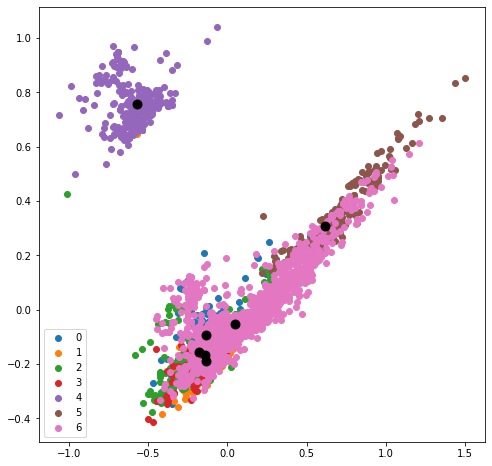

/Users/mamadoubelladiallo/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



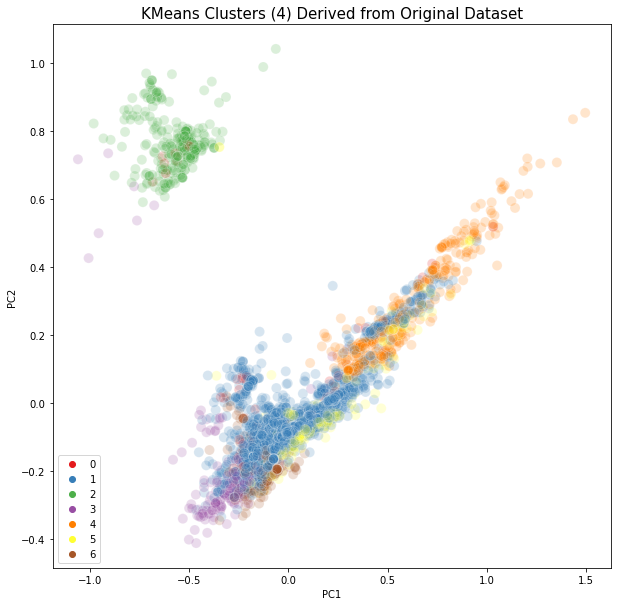

recipes_db 5468
{7: Counter({7: 237}), 8: Counter({8: 180}), 9: Counter({9: 399}), 10: Counter({10: 234}), 11: Counter({11: 349}), 12: Counter({12: 295}), 13: Counter({13: 3774})}


In [46]:
n_clusters = 7
n_component = 150
file_name = '_third'
k,d = kmeans(dataset1,n_clusters,n_component)
pca(dataset1,n_clusters,n_component)
linkCluster(k,d,listRecette,n_clusters,file_name)
data = readJson('data/_third.json')
f = lambda data: data['cluster']
dct = {k: Counter(d['cluster'] for d in g) for k, g in groupby(data, f)}
print(dct)
# with open("data/doneDataset.json", "w") as outfile:
    # json.dump(doneDataset, outfile)

In [110]:
# Silhouette analysis can be used to study the separation distance between the resulting clusters
def silhouetteAvant(dataset):
    kmeans_scale = KMeans(n_clusters=5, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(dataset)
    silhouette = silhouette_score(dataset, kmeans_scale.labels_, metric='euclidean')
    print('KMeans Scaled Silhouette Score Avant: {}'
          .format(silhouette_score(dataset, kmeans_scale.labels_, metric='euclidean')))
    labels_scale = kmeans_scale.labels_
    return silhouette

In [111]:
def silhouetteStats(s1,s2):
    # creating the dataset
    s1 = s1 * 100
    s2 = s2 * 100
    data = {'Silhouette sans PCA':s2, 'Silhouette avec PCA':s1}
    label = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(label, values,
            width = 0.4)

    plt.ylabel("Valeur en pourcentage de la silhouette ")
    plt.title("Silhouette Analysis")
    plt.show()

KMeans Scaled Silhouette Score Avant: 0.5921779050363792
KMeans Scaled Silhouette Score Avant: 0.072385128087087


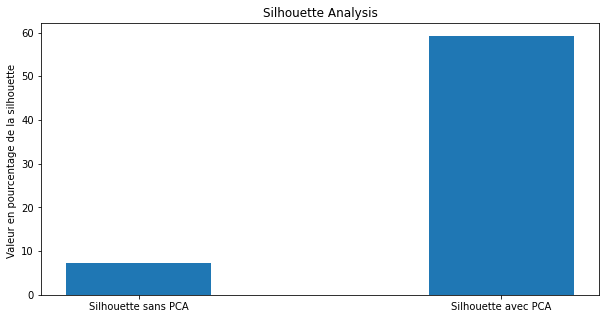

0.5921779050363792


In [116]:
s1 = silhouetteAvant(pca_scale)
s2 = silhouetteApres(dataset1)
silhouetteStats(s1,s2)
print(s1)

In [5]:
descr= ['ab','bb','bc']
descrx = ('||').join(descr)
print(descrx)
for x in descr:
   print(x[0])

ab||bb||bc
a
b
b
